# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

Yomna Hesham Amin Fekry  *(G19093453)*

Ahmed Mohamed Farouk  *(2000630)*

This is an implementation to the paper **"A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network"**. 

The author of the paper said that the proposed algorithm is implemented in Matlab, but we cannot find this implementation, so we implemented it in Python


# Imports


In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


# Variables Definitions

In [4]:
path = 'mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepere Input Files

In [5]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [6]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Extraction and Preprocessing

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\root\AppData\Local\Temp\ipykernel_17160\3133449120.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\root\AppData\Local\Temp\ipykernel_17160\3133449120.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\root\AppData\Local\Temp\ipykernel_17160\3133449120.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\root\AppData\Local\Temp\ipykernel_17160\3133449120.py:57: SyntaxWarning: "is" with a liter

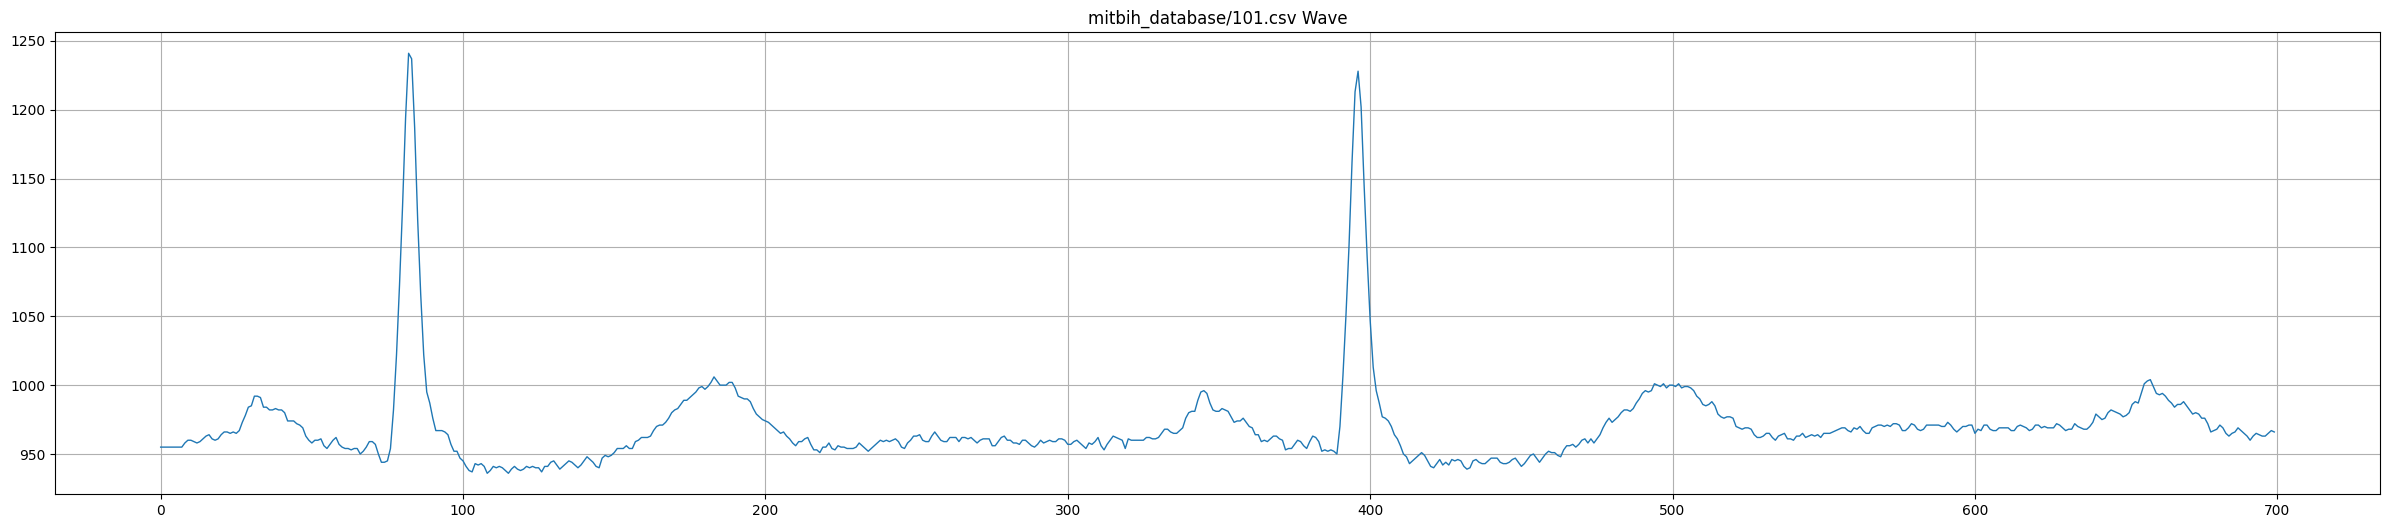

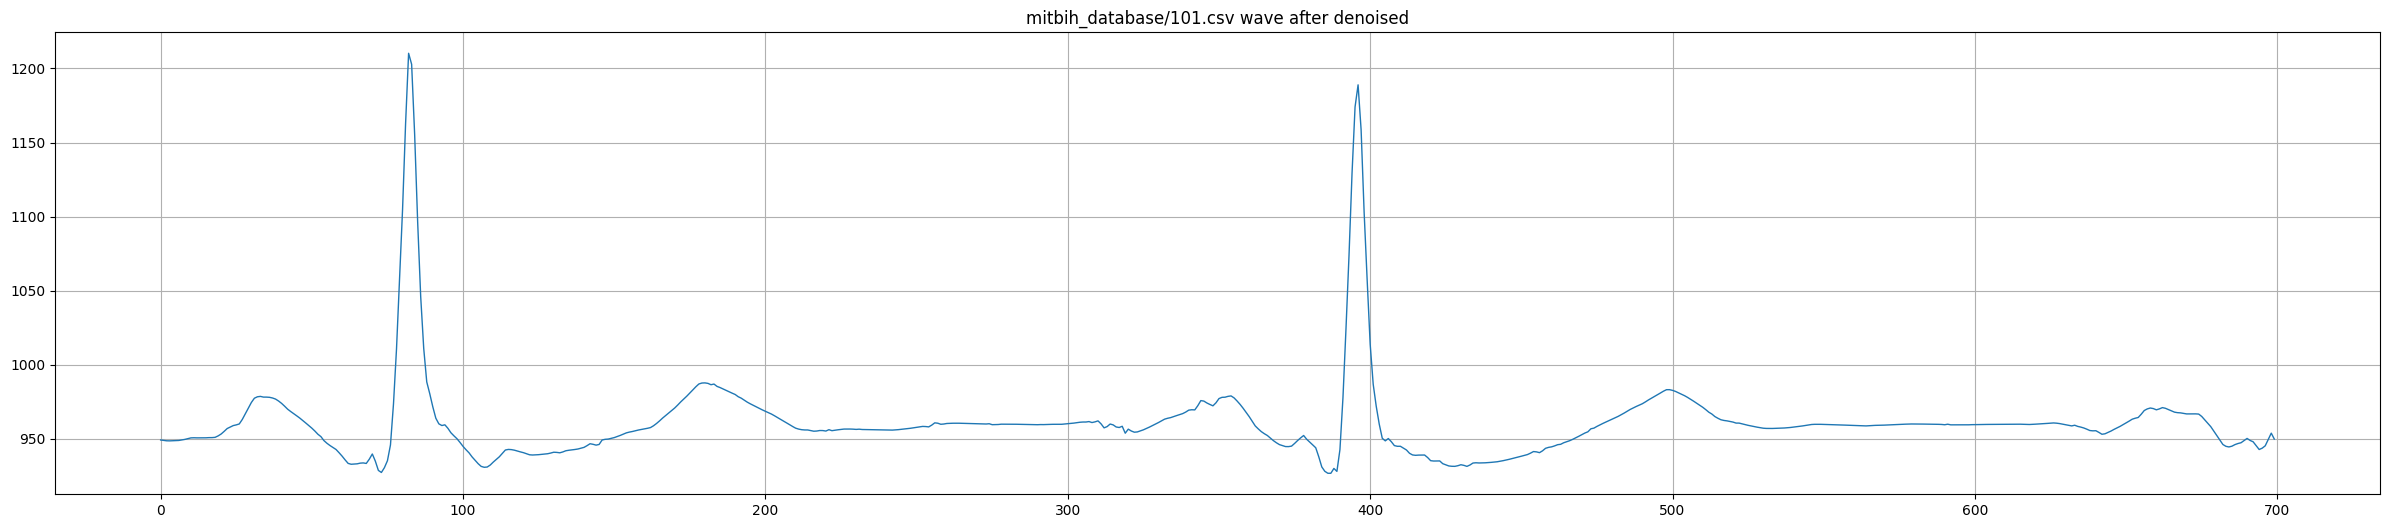

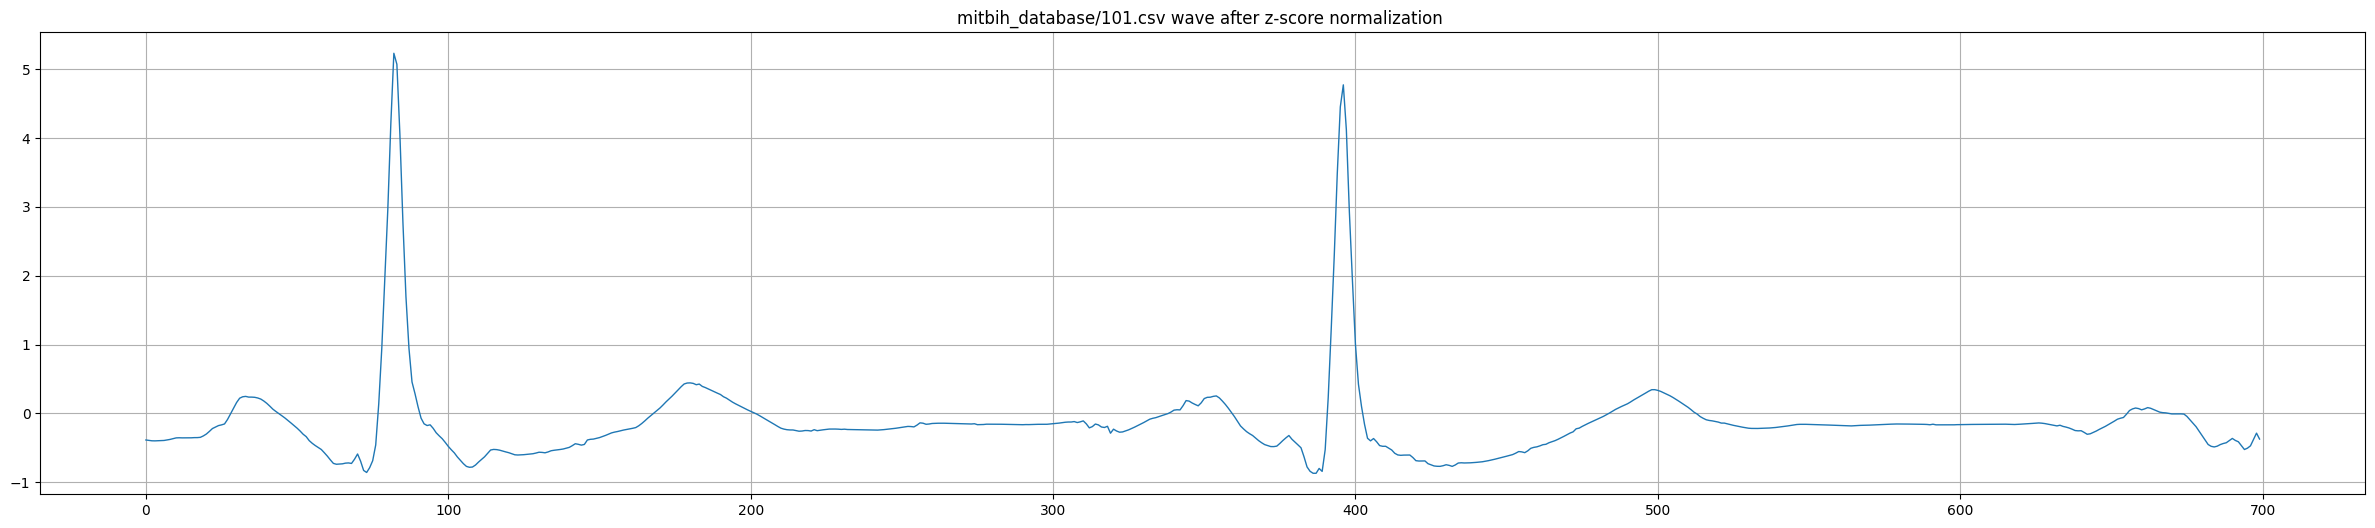

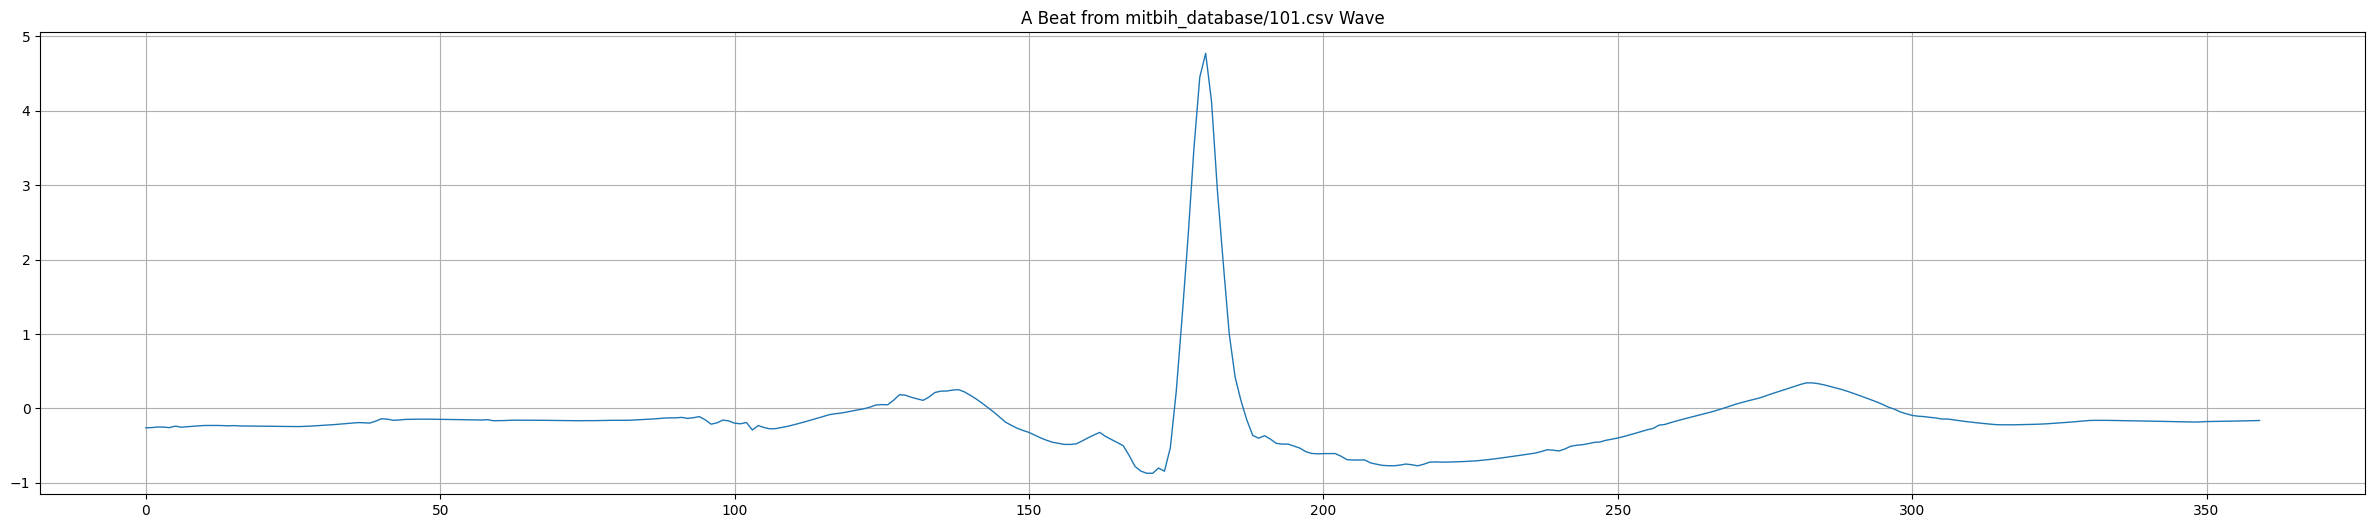

(100012, 360) (100012,)


In [7]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


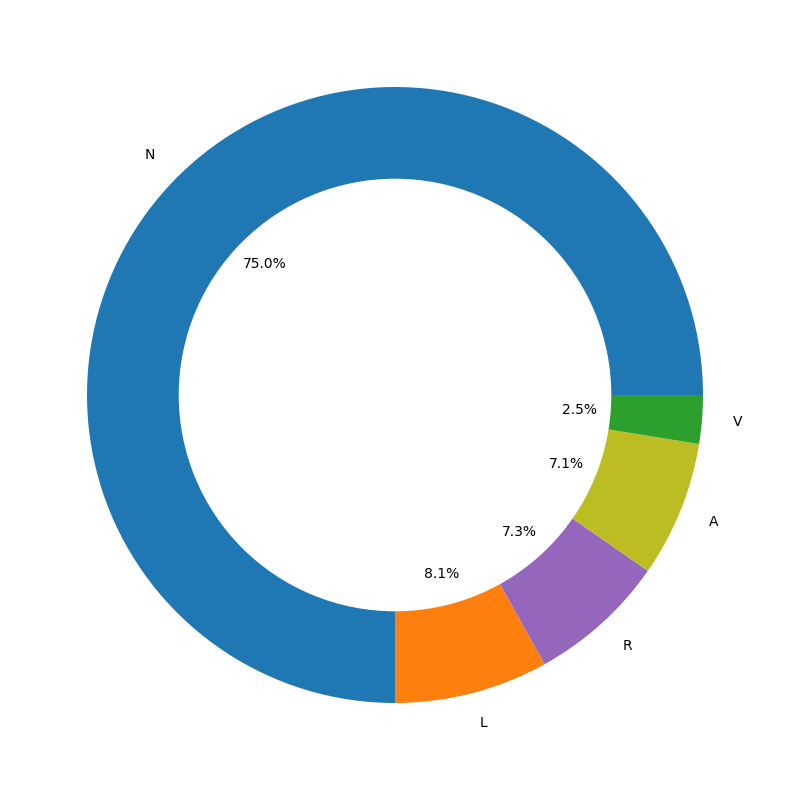

In [9]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes

In [10]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: count, dtype: int64


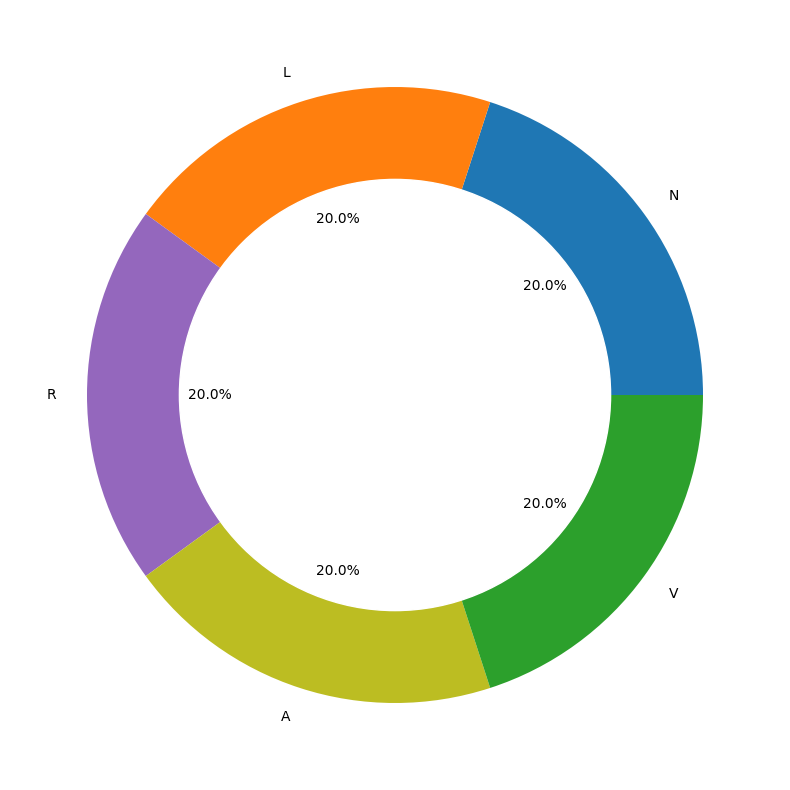

In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [12]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [13]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [14]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


## Building the Model Architecture


In [15]:
model = Sequential()

model.add(LSTM(32, return_sequences=True, activation='tanh', input_shape=(360,1)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 360, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 360, 64)           24832     
                                                                 
 lstm_2 (LSTM)               (None, 360, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 97477 (380.77 KB)
Trainable params: 97477 

## Compiling the model

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [17]:
print(train_x.shape)

(20000, 360, 1)


## Fitting the model

In [18]:
history = model.fit(train_x, train_y, batch_size=32, epochs=25, verbose=1, validation_data=(test_x, test_y))

Epoch 1/25
625/625 [==============================] - 154s 239ms/step - loss: 1.4283 - accuracy: 0.3767 - val_loss: 1.6283 - val_accuracy: 0.2364
Epoch 2/25
625/625 [==============================] - 146s 234ms/step - loss: 1.5114 - accuracy: 0.3167 - val_loss: 1.4204 - val_accuracy: 0.3720
Epoch 3/25
625/625 [==============================] - 149s 238ms/step - loss: 1.2280 - accuracy: 0.5021 - val_loss: 1.0482 - val_accuracy: 0.5950
Epoch 4/25
625/625 [==============================] - 151s 242ms/step - loss: 0.9575 - accuracy: 0.6495 - val_loss: 0.8505 - val_accuracy: 0.6964
Epoch 5/25
625/625 [==============================] - 182s 291ms/step - loss: 0.8871 - accuracy: 0.6804 - val_loss: 0.6928 - val_accuracy: 0.7610
Epoch 6/25
625/625 [==============================] - 183s 293ms/step - loss: 0.6653 - accuracy: 0.7725 - val_loss: 0.5166 - val_accuracy: 0.8186
Epoch 7/25
625/625 [==============================] - 182s 291ms/step - loss: 0.5337 - accuracy: 0.8181 - val_loss: 0.4412 -

**Plotting the loss convergence**

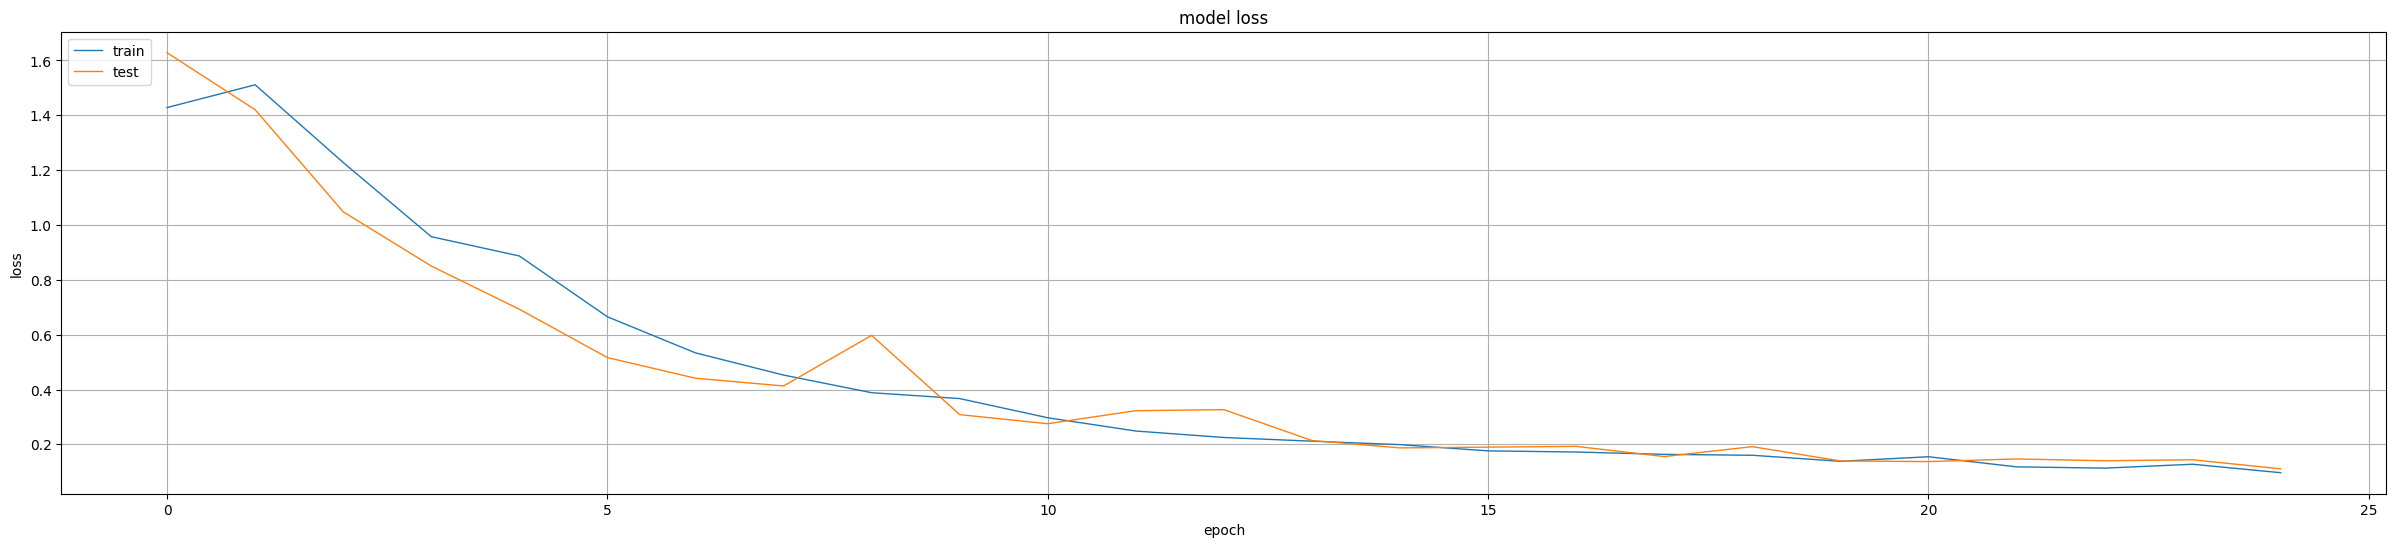

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

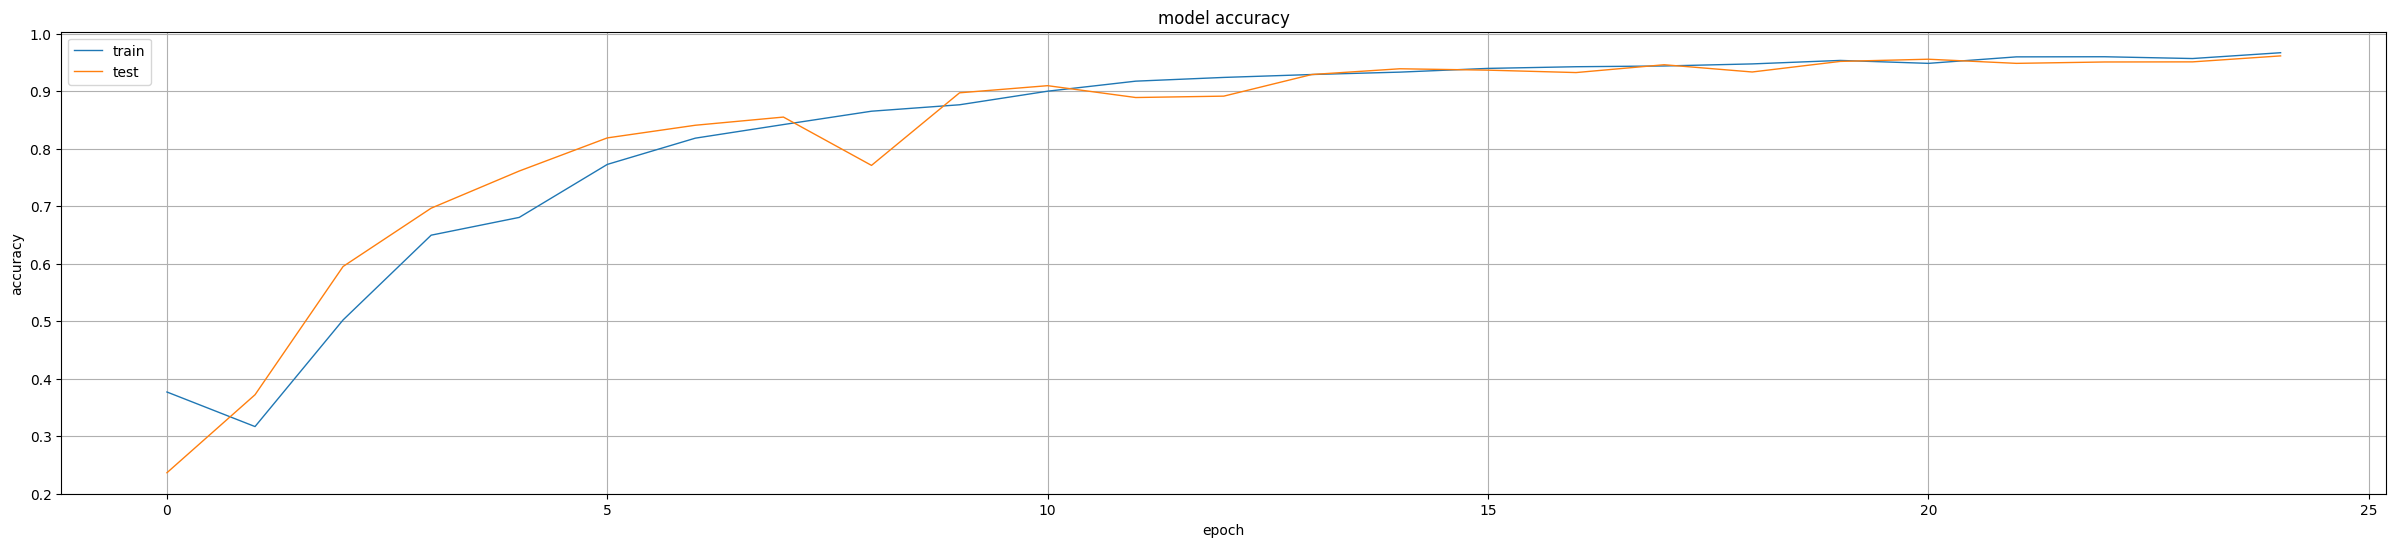

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Finding the loss and accuracy of the model

In [21]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 15s 97ms/step - loss: 0.1109 - accuracy: 0.9612
Test Loss: 0.11090196669101715
Test accuracy: 0.9611999988555908


In [22]:
model.save('LSTM.h5')

C:\Users\root\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
